# Debugging the design

In [1]:
%load_ext autoreload
%autoreload 2

import uuid
import argparse
import dgym as dg
import pandas as pd

def get_data(path):

    deck = dg.MoleculeCollection.load(
        f'{path}/DSi-Poised_Library_annotated.sdf',
        reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
    )

    reactions = dg.ReactionCollection.from_json(
        path = f'{path}/All_Rxns_rxn_library_sorted.json',
        smarts_col = 'reaction_string',
        classes_col = 'functional_groups'
    )

    building_blocks = dg.datasets.disk_loader(
        f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
    fingerprints = dg.datasets.fingerprints(
        f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

    import torch
    import pyarrow.parquet as pq
    table = pq.read_table(f'{path}/sizes.parquet')[0]
    sizes = torch.tensor(table.to_numpy())

    return deck, reactions, building_blocks, fingerprints, sizes

In [2]:
_, reactions, building_blocks, fingerprints, sizes = get_data('../../dgym-data/')

In [3]:
from dgym.envs.designer import Designer, Generator

generator = Generator(building_blocks, fingerprints, sizes)
designer = Designer(generator, reactions)

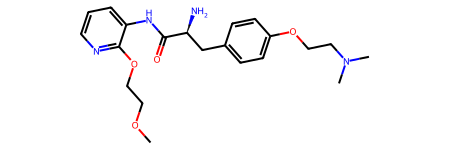

temperature 0.5 limit 1


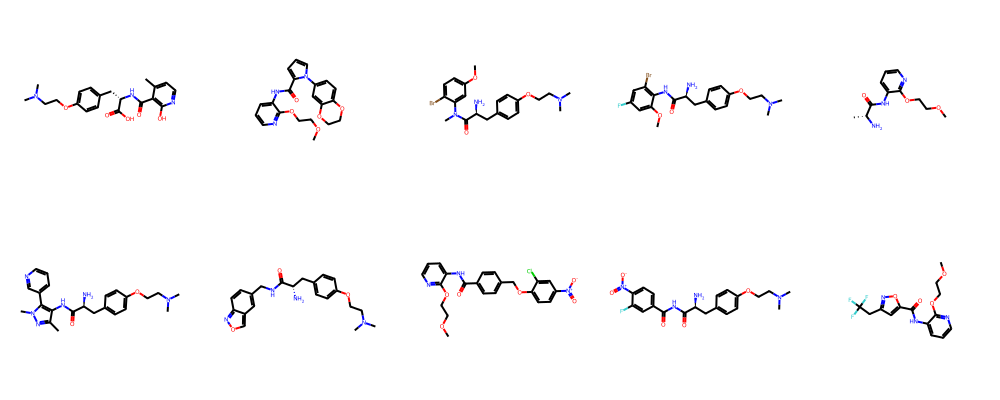

In [98]:
# start = designer.design(1)[0]

limit = 1
temperature = 0.5
designer.reset()
res = designer.design(
    start, 10, temperature=temperature,
    limit=limit
)

# gen = designer.generator([start.reactants[1]], search='similar', temperature=0.04)
# mols = [next(gen[0]).mol for _ in range(10)]

from rdkit.Chem.Draw import MolsToGridImage
display(start)
print('temperature', temperature, 'limit', limit)
MolsToGridImage([r.mol for r in res], molsPerRow=5)